# Importación de librerías

In [2]:
import pandas as pd
import numpy as np

# Importación de productos_dia.csv

In [23]:
df = pd.read_csv("/content/productos_dia.csv")
df.head(3)

,name,description,price,reference_price,reference_unit,product_id,insert_date,category,subcategory
0,Patatas gajo Patatas Unidas Dia bolsa 750 g,bolsa,1.80,2.40,KILO,262685,2025-04-08,Freidora de aire - Airfryer,Patatas Airfryer
1,Patatas finas prefritas Patatas Unidas Dia bol...,bolsa,1.93,1.93,KILO,262863,2025-04-08,Freidora de aire - Airfryer,Patatas Airfryer
2,Patatas prefritas Patatas Unidas Dia bolsa 1 Kg,bolsa,1.85,1.85,KILO,262861,2025-04-08,Freidora de aire - Airfryer,Patatas Airfryer


# Análisis inicial del DataFrame

### Dimensión, estructura y tipos de datos

Utilizamos df.info() para mostrar la estructura del DataFrame. Este paso nos permite:

1. Ver cuántas filas y columnas tiene el conjunto de datos

2. Identificar los tipos de datos

3. Detectar columnas que deben ser convertidas, como insert_date (que debería ser tipo fecha)

4. Evaluar el uso de memoria

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6123 entries, 0 to 6122
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             6123 non-null   object 
 1   description      6118 non-null   object 
 2   price            6123 non-null   float64
 3   reference_price  6123 non-null   float64
 4   reference_unit   6123 non-null   object 
 5   product_id       6123 non-null   object 
 6   insert_date      6123 non-null   object 
 7   category         6123 non-null   object 
 8   subcategory      6123 non-null   object 
dtypes: float64(2), object(7)
memory usage: 430.7+ KB


### Duplicados y nulos

Eliminamos filas duplicadas completas, es decir, aquellas donde todos los valores de todas las columnas son iguales.

In [25]:
df = df.drop_duplicates()

In [26]:
df.shape[0]

6123

Tras ejecutar df.drop_duplicates(), el número de filas no se redujo. Esto indica que no existían registros completamente duplicados.

Calculamos el número de valores nulos por cada columna.

In [27]:
df.isnull().sum()

,0
name,0
description,5
price,0
reference_price,0
reference_unit,0
product_id,0
insert_date,0
category,0
subcategory,0


Solo hay 5 valores nulos en la columna description. Todas las demás columnas, incluyendo product_id, name, price, reference_price, reference_unit, category y subcategory, están completamente completas. Decidimos mantener estas filas tal como están, ya que la columna description no es crítica para los análisis principales ni para la clasificación.

# Detección y corrección de anomalías en los precios

Analizamos la distribución general de los precios.

In [28]:
df[['price', 'reference_price']].describe()

,price,reference_price
count,6123.000000,6123.000000
mean,3.227743,12.956400
std,3.016228,139.972027
min,0.240000,0.010000
25%,1.550000,1.920000
50%,2.390000,5.730000
75%,3.750000,11.960000
max,34.990000,6875.000000


Hemos revisado las estadísticas básicas de las columnas price y reference_price.

1. Precio (price). La mayoría de los productos tienen precios razonables: el precio medio es de 3,23 €, el precio más alto es de 34,99€, lo que probablemente corresponde a productos premium o grandes formatos.

2. Precio de referencia (reference_price). En este campo sí se observa algo curioso: aunque el valor medio es de 12,96€, hay un valor máximo extremadamente alto (6875€ por unidad) y una desviación estándar muy grande (139,97€). Esto sugiere que hay valores atípicos o errores, que analizaremos para ver si se pueden corregir o excluir.

Con el objetivo de detectar visualmente la presencia de valores extremos o errores de registro en los precios, generamos dos diagramas de caja: boxplot del campo price y boxplot del campo reference_price.

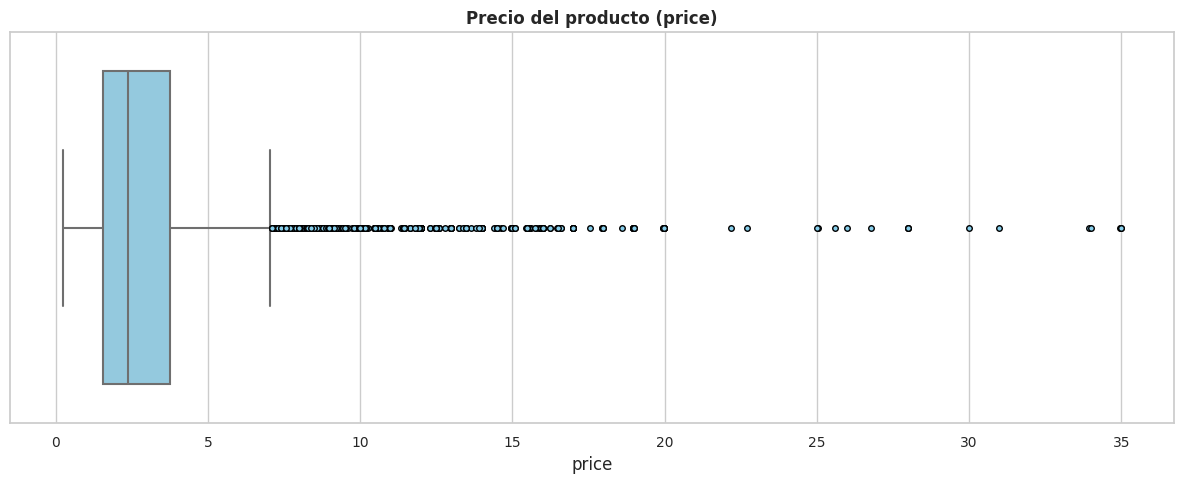

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme(style="whitegrid", palette="pastel")

flier_props = dict(marker='o', markerfacecolor='skyblue', markersize=4, linestyle='none', markeredgecolor='black')

plt.figure(figsize=(12, 5))
sns.boxplot(
    x=df['price'],
    color='skyblue',
    fliersize=4,
    linewidth=1.5,
    flierprops=flier_props
)

plt.title('Precio del producto (price)', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

Este gráfico tipo boxplot muestra la distribución de los precios de los productos (price) en el supermercado. La mayoría de los productos tienen precios entre 1,5€ y 4€. A partir de unos 7€ comienzan a aparecer muchos valores atípicos (outliers). Algunos precios superan los 30€, pero son casos puntuales. En resumen, el gráfico confirma que los precios extremos existen, pero no parecen ser errores evidentes, sino productos con precios altos por su naturaleza o tamaño.

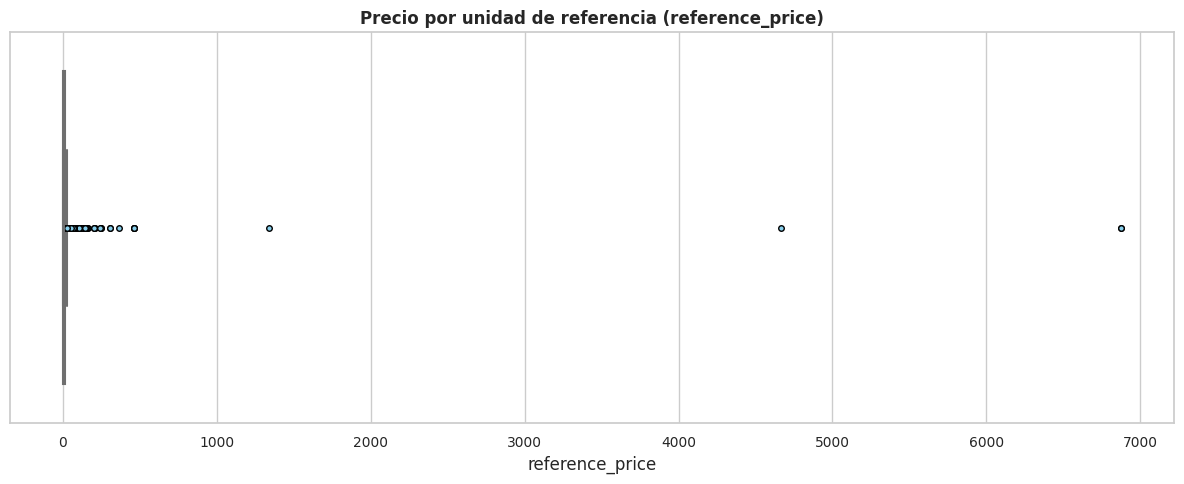

In [30]:
sns.set_theme(style="whitegrid", palette="pastel")

flier_props = dict(marker='o', markerfacecolor='skyblue', markersize=4, linestyle='none', markeredgecolor='black')

plt.figure(figsize=(12, 5))
sns.boxplot(
    x=df['reference_price'],
    color='skyblue',
    fliersize=4,
    linewidth=1.5,
    flierprops=flier_props)

plt.title('Precio por unidad de referencia (reference_price)', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

Podemos ver que la mayoría de los productos tienen un precio por unidad razonable, pero se observan outliers extremos que superan los 1000, 4000 y hasta unos 6800€/unidad. Estos valores muy elevados podrían deberse a errores en la cantidad de referencia o a productos mal registrados. Vamos a inspeccionar manualmente estos productos para verificar si se trata de errores de conversión o precios realmente fuera del estándar.

Para entender el origen de los precios anormalmente altos, vamos a examinar en detalle los productos con los valores más elevados en las columnas price y reference_price. Esto nos ayudará a identificar si los outliers están asociados a ciertas categorías, errores de registro o características del producto (como formatos o presentaciones especiales).

In [31]:
# Ordenamos el DataFrame por la columna 'price' en orden descendente
# para obtener los productos con el precio más alto
top_20_price = df.sort_values(by='price', ascending=False).head(20)
top_20_price


,name,description,price,reference_price,reference_unit,product_id,insert_date,category,subcategory
5499,Crema de día collagen peptide 24 Olay 50 ml,50 ml,34.99,69.98,100 ML.,278462,2025-04-08,"Perfumería, higiene, salud","Limpieza facial, crema facial"
5505,Crema de día hyaluronic24 + vitamina B5 Olay e...,50 ml,34.99,69.98,100 ML.,255920,2025-04-08,"Perfumería, higiene, salud","Limpieza facial, crema facial"
5498,Crema de día vitamina C + AHA24 Olay 50 ml,50 ml,34.95,69.90,100 ML.,283715,2025-04-08,"Perfumería, higiene, salud","Limpieza facial, crema facial"
4410,Ginebra nº ten Tanqueray 70 cl,NaN,33.99,48.56,LITRO,187010,2025-04-08,"Cervezas, vinos y bebidas con alcohol",Ginebra y vodka
1278,Aceite de oliva virgen extra Dcoop garrafa 3 l,3 l,33.94,11.31,LITRO,283358,2025-04-08,"Aceites, salsas y especias",Aceites
4441,Whisky 12 años Chivas botella 70 cl,botella,30.99,44.27,LITRO,104215,2025-04-08,"Cervezas, vinos y bebidas con alcohol",Ron y whisky
5519,Crema Regenerist anti-edad intensiva Olay 50 ml,50 ml,29.99,59.98,100 ML.,153642,2025-04-08,"Perfumería, higiene, salud","Limpieza facial, crema facial"
1287,Aceite de oliva suave La Almazara del Olivar d...,5 l,28.00,5.60,LITRO,49895,2025-04-08,"Aceites, salsas y especias",Aceites
1277,Aceite de oliva intenso La Almazara del Olivar...,5 l,28.00,5.60,LITRO,107364,2025-04-08,"Aceites, salsas y especias",Aceites
4442,Ron solera gran reserva Zacapa botella 35 cl,botella,27.99,79.97,LITRO,302651,2025-04-08,"Cervezas, vinos y bebidas con alcohol",Ron y whisky


Los productos con los precios más altos en DIA están dominados por tres grandes grupos:

- cosmética facial de alta gama;

- bebidas alcohólicas premium como ginebras, ron, whisky y vino tinto;

- productos gourmet o especiales como aceites de oliva virgen extra y algún producto de mascotas de gran formato.

No se identifican errores ni valores claramente anómalos. Por tanto, no es necesario realizar ninguna transformación o limpieza adicional en este grupo de productos.

Ahora hacemos lo mismo pero con la columna 'reference_price' que indica el precio por unidad (€/kg, €/l, etc.)

In [32]:
top_20_reference_price = df.sort_values(by='reference_price', ascending=False).head(20)
top_20_reference_price

,name,description,price,reference_price,reference_unit,product_id,insert_date,category,subcategory
1509,Azafrán molido Pote caja 4 sobres 100 mg,caja,2.75,6875.00,KILO,147512,2025-04-08,"Aceites, salsas y especias",Sal y especias
1510,Azafrán en hebras Pote caja 4 sobres 100 mg,caja,2.75,6875.00,KILO,147509,2025-04-08,"Aceites, salsas y especias",Sal y especias
1469,Azafrán en hebras Safrina caja 0.375 g,caja,1.75,4666.67,KILO,119016,2025-04-08,"Aceites, salsas y especias",Sal y especias
4455,Vermouth rojo Nordés botella 1 cl,botella,13.39,1339.00,LITRO,304154,2025-04-08,"Cervezas, vinos y bebidas con alcohol",Vermouth
4904,Ambientador para coche y hogar té verde Imaqe ...,4 ml,1.85,462.50,LITRO,297714,2025-04-08,Limpieza y hogar,Ambientadores
4872,Ambientador para coche y hogar chicle de fresa...,4 ml,1.85,462.50,LITRO,297716,2025-04-08,Limpieza y hogar,Ambientadores
4903,Ambientador para coche y hogar coche nuevo Ima...,4 ml,1.85,462.50,LITRO,297715,2025-04-08,Limpieza y hogar,Ambientadores
4867,Ambientador para coche y hogar coco Imaqe de D...,4 ml,1.85,462.50,LITRO,297717,2025-04-08,Limpieza y hogar,Ambientadores
1953,Aroma de vainilla Dr. Oetker blister 8 g,8 g,2.89,361.25,KILO,178094,2025-04-08,"Panes, harinas y masas",Preparados para postres
4905,Ambientador para coche y hogar lima Imaqe de D...,caja,1.85,308.33,LITRO,296740,2025-04-08,Limpieza y hogar,Ambientadores


Los productos con precios de referencia más altos incluyen, en su mayoría, especias de alto valor como el azafrán, que justifican su elevado coste por unidad debido a su concentración y tamaño reducido. Sin embargo, Hemos detectado un error evidente en uno de los productos:
el vermut rojo Nordés aparece con un reference_price de 1339 €/l, cuando en realidad, en otros supermercados el mismo producto cuesta alrededor de 13 €/l.
Al analizar el campo description, vemos que el volumen indicado es 1 cl, lo cual parece ser un error tipográfico, ya que en la página web oficial del supermercado este producto se vende en botella de 1 litro. Este error en la descripción ha provocado un cálculo erróneo del reference_price. Por lo tanto, vamos a corregir esta entrada manualmente, ajustando la unidad y el precio de referencia para reflejar el valor real.

In [33]:
# Corrección utilizando el product_id
df.loc[df['product_id'] == '304154', 'name'] = 'Vermouth rojo Nordés botella 1 l'
df.loc[df['product_id'] == '304154', 'reference_price'] = 13.39

Es importante revisar también los productos con los valores más bajos de price. Este análisis nos permite detectar posibles errores en el rango inferior, como precios inusualmente bajos causados por errores de entrada o redondeo. A continuación, mostramos los 10 productos con el precio más bajo del conjunto de datos.

In [34]:
# Seleccionamos los 10 productos con el precio más bajo
top_10_mas_baratos = df.sort_values(by='price', ascending=True).head(10)
top_10_mas_baratos

,name,description,price,reference_price,reference_unit,product_id,insert_date,category,subcategory
3643,Agua mineral natural Dia botella 50 cl,botella,0.24,0.48,LITRO,37776,2025-04-08,"Agua, refrescos y zumos",Agua
3640,Agua mineral natural Dia botella 1.5 l,botella,0.25,0.17,LITRO,26995,2025-04-08,"Agua, refrescos y zumos",Agua
3651,Agua mineral natural Dia botella 33 cl,botella,0.26,0.79,LITRO,50567,2025-04-08,"Agua, refrescos y zumos",Agua
1803,Pan viena integral (50%) El molino de Dia 80 g,80 g,0.27,3.38,KILO,274757,2025-04-08,"Panes, harinas y masas",Pan recien horneado
1797,Barra de pan El molino de Dia bolsa 125 g,bolsa,0.29,2.32,KILO,169479,2025-04-08,"Panes, harinas y masas",Pan recien horneado
3650,Agua mineral con gas Dia botella 50 cl,botella,0.29,0.58,LITRO,24874,2025-04-08,"Agua, refrescos y zumos",Agua
4002,Cerveza lager Ramblers de Dia lata 33 cl,lata,0.31,0.94,LITRO,192,2025-04-08,"Cervezas, vinos y bebidas con alcohol",Cervezas
3833,Gaseosa cero Gaseosa Dia botella 50 cl,botella,0.32,0.64,LITRO,43891,2025-04-08,"Agua, refrescos y zumos",Gaseosa
3744,Refresco de cola zero sin cafeína Hola Cola de...,lata,0.33,1.00,LITRO,222479,2025-04-08,"Agua, refrescos y zumos",Cola
3818,Tónica zero Toni Tónico de Dia lata 25 cl,lata,0.33,1.32,LITRO,301838,2025-04-08,"Agua, refrescos y zumos",Tónicas


Como se observa, la mayoría precios más bajos corresponden a botellas de agua mineral y bebidas en lata, con precios entre 0,24€ y 0,33€. También aparecen algunos productos de panadería, como el pan integral o barras de pan, que mantienen un coste muy accesible por unidad. Todos los precios parecen razonables, y no se detectan errores evidentes en esta muestra. Estos productos tienen un precio total bajo, aunque sus precios por unidad de referencia pueden variar en función del volumen o peso del envase. No se requiere ninguna corrección en esta sección.

Ahora vamos a ver también los productos con los precios por unidad (reference_price) más bajos. Así podemos comprobar si hay valores demasiado bajos que no tienen sentido o si todo está correcto.

In [35]:
# Seleccionamos los 10 productos con el reference_price más bajo
top_10_mas_baratos_reference_price = df.sort_values(by='reference_price', ascending=True).head(10)
top_10_mas_baratos_reference_price

,name,description,price,reference_price,reference_unit,product_id,insert_date,category,subcategory
5908,Toallitas húmedas Planeta Bebé de Dia bolsa 80...,bolsa,1.05,0.01,UNIDAD,296947,2025-04-08,Bebé,Pañales y toallitas
2170,Edulcorante Dia frasco 150 unidades,unidad,1.70,0.01,UNIDAD,210776,2025-04-08,"Azúcar, chocolates y caramelos",Azúcar y edulcorantes
4616,Pañuelos faciales La Llama Dia caja 150 unidades,caja,0.94,0.01,UNIDAD,276698,2025-04-08,Limpieza y hogar,"Papel higiénico, de cocina, servilletas"
4612,Servilletas blancas 1 capa La Llama Dia bolsa ...,bolsa,1.25,0.01,UNIDAD,276692,2025-04-08,Limpieza y hogar,"Papel higiénico, de cocina, servilletas"
2169,Edulcorante Natreen caja 400 unidades,caja,4.09,0.01,UNIDAD,187421,2025-04-08,"Azúcar, chocolates y caramelos",Azúcar y edulcorantes
5779,Bastoncillos de algodón con palo de papel Imaq...,caja,1.00,0.01,UNIDAD,283889,2025-04-08,"Perfumería, higiene, salud",Parafarmacia
5780,Discos de algodón desmaquillantes redondos Ima...,bolsa,0.84,0.01,UNIDAD,283887,2025-04-08,"Perfumería, higiene, salud",Parafarmacia
2553,Cono chuches celebración sin gluten Midel bols...,bolsa,1.25,0.02,UNIDAD,249986,2025-04-08,"Azúcar, chocolates y caramelos","Caramelos, chicles y golosinas"
4626,Papel higiénico húmedo Planeta Junior de Dia b...,bolsa,1.89,0.02,UNIDAD,288728,2025-04-08,Limpieza y hogar,"Papel higiénico, de cocina, servilletas"
5682,Protegeslips clásico Esos Dias caja 40 unidades,caja,0.99,0.02,UNIDAD,283821,2025-04-08,"Perfumería, higiene, salud",Compresas y cuidado íntimo


Se destacan artículos como toallitas húmedas, pañuelos, bastoncillos de algodón, discos desmaquillantes, edulcorantes y servilletas. Todos estos productos tienen un precio por unidad extremadamente bajo, entre 0.01€ y 0.02€, lo cual es coherente con su naturaleza de productos de higiene o uso doméstico con alta cantidad por envase (80–400 unidades por caja). Todos los valores parecen razonables y no se identifican anomalías. No se requieren ajustes en esta sección.

Para visualizar de forma más clara la distribución de los precios de todos los productos del supermercado, generamos un histograma que muestra la cantidad de artículos en cada rango de precio.

<Axes: >

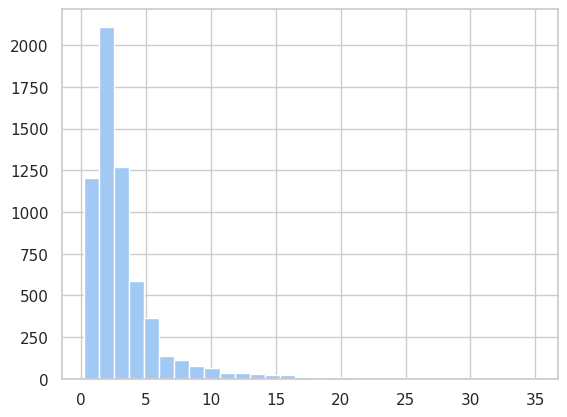

In [36]:
# La distribución final de los precios
df["price"].hist(bins=30)

La mayoría de los productos tienen un precio entre 1 y 5 euros, con un pico en torno a los 2–3 euros. La distribución es asimétrica con una cola larga hacia la derecha, lo que indica que existe un pequeño número de artículos con precios elevados (superiores a 15–20 euros). Esto es coherente con el tipo de tienda, donde predominan productos de consumo básico y precios accesibles.

<Axes: >

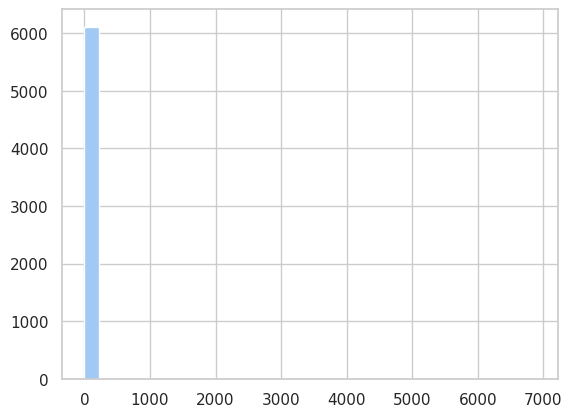

In [17]:
# La distribución final de reference_price
df["reference_price"].hist(bins=30)

La distribución del reference_price es altamente asimétrica: casi todos los valores están agrupados cerca de 0-10, mientras que unos pocos productos presentan precios por unidad extremadamente altos (hasta 7000). Esto distorsiona la escala del gráfico.

# Análisis de valores únicos en campos clave

En esta etapa analizamos la cantidad de valores únicos en columnas esenciales del conjunto de datos, como el identificador del producto, el nombre, la categoría y la subcategoria. Conocer los valores únicos es útil para evaluar la diversidad de los datos y detectar posibles inconsistencias.

In [37]:
num_unique_id = df['product_id'].nunique()
num_unique_id

5937

El dataset contiene 6123 registros y 5937 identificadores únicos (id), lo que significa que hay 186 productos repetidos según su id.
Esto puede deberse a duplicaciones exactas, distintas versiones de un mismo producto o errores de carga. Vamos a identificar los id que aparecen más de una vez y analizar sus diferencias.

In [19]:
# Contamos cuántas veces aparece cada 'id'
id_counts = df['product_id'].value_counts()

# Filtramos los 'id' que se repiten más de una vez
duplicados_id = id_counts[id_counts > 1].index
print(f'Cantidad de filas que tienen los id duplicados: {len(duplicados_id)}')

# Extraemos las filas correspondientes a esos 'id' duplicados
df_duplicados_id = df[df['product_id'].isin(duplicados_id)].copy()

# Mostramos 20 filas como ejemplo para analizarlos manualmente
df_duplicados_id.sort_values(by='product_id').head(20)

Cantidad de filas que tienen los id duplicados: 172


,name,description,price,reference_price,reference_unit,product_id,insert_date,category,subcategory
3585,Alcachofa troceada Vegecampo de Dia bolsa 400 g,bolsa,2.65,6.63,KILO,10242,2025-04-08,Congelados,"Verduras, hortalizas y salteados"
36,Alcachofa troceada Vegecampo de Dia bolsa 400 g,bolsa,2.65,6.63,KILO,10242,2025-04-08,Freidora de aire - Airfryer,Verduras Airfryer
288,Queso mozzarella fresca Selección Mundial de D...,bolsa,1.05,8.40,KILO,108698,2025-04-08,Charcutería y quesos,Queso fresco
351,Queso mozzarella fresca Selección Mundial de D...,bolsa,1.05,8.40,KILO,108698,2025-04-08,Charcutería y quesos,Quesos internacionales
3769,Zumo naranja exprimido sin pulpa Zumosfera de ...,botella,2.00,2.00,LITRO,109413,2025-04-08,"Agua, refrescos y zumos",Naranja
3918,Zumo naranja exprimido sin pulpa Zumosfera de ...,botella,2.00,2.00,LITRO,109413,2025-04-08,"Agua, refrescos y zumos",Zumos
4173,"Cerveza radler con limón 0,0% alcohol San Migu...",lata,0.75,2.27,LITRO,125715,2025-04-08,"Cervezas, vinos y bebidas con alcohol",Cervezas sin alcohol
4139,"Cerveza radler con limón 0,0% alcohol San Migu...",lata,0.75,2.27,LITRO,125715,2025-04-08,"Cervezas, vinos y bebidas con alcohol",Cervezas con limón
1749,Pasta oriental yakisoba classic Fusian sobre 1...,sobre,1.99,16.58,KILO,127112,2025-04-08,"Conservas, caldos y cremas","Sopas, caldos y purés deshidratados"
3320,Pasta oriental yakisoba classic Fusian sobre 1...,sobre,1.99,16.58,KILO,127112,2025-04-08,Pizzas y platos preparados,Comida internacional


En esta revisión manual de productos con id duplicado, observamos que las filas comparten los mismos valores en todas las columnas clave como name, description, price, y reference_price, pero se diferencian en la categoria y subcategorís asignadas. Esto indica que se trata del mismo producto clasificado en diferentes subcategorías.

Hemos decidido no forzar la asignación de cada producto a una única categoría por las siguientes razones:

1. Algunos productos tienen una naturaleza ambigua o transversal, y aparecen de forma legítima en más de una categoría o subcategoría.

2. Al eliminar una de esas asignaciones, existe el riesgo de dejar ciertas categorías incompletas, lo que puede afectar negativamente al análisis posterior (por ejemplo, al comparar precios medios, cantidades o cobertura de surtido).

3. Si forzamos la asignación a una sola categoría, podríamos obtener una categoría "con datos completos" y otra artificialmente reducida, lo cual distorsionaría los resultados del análisis comparativo entre supermercados o entre familias de productos.

Por estas razones, hemos optado por conservar todos los registros tal como aparecen originalmente, permitiendo que un mismo producto pueda pertenecer a varias categorías si así se refleja en los datos. Esto nos permite mantener una visión más completa y precisa del surtido real.

Verificamos si existen productos duplicados que tienen todas las características iguales (nombre, descripción, precio, unidad de referencia, categorías y subcategorías), pero con identificadores id diferentes. Para detectarlos, agrupamos por todas las columnas excepto el product_id, y seleccionamos aquellos grupos en los que aparece más de un id distinto.

In [38]:
# Especificamos las columnas que deben coincidir completamente (excepto 'product_id')
columnas_comparacion = [
    'name', 'description', 'price', 'reference_price', 'reference_unit',
    'category', 'subcategory']

# Agrupamos por esas columnas y contamos cuántos product_id distintos hay en cada grupo
grupos = df.groupby(columnas_comparacion)['product_id'].nunique().reset_index(name='conteo_id')

# Seleccionamos solo los grupos donde hay más de un product_id distinto
grupos_con_multiples_id = grupos[grupos['conteo_id'] > 1]

# Hacemos merge para extraer las filas originales que coinciden con estos grupos
df_casi_igual_id_dist = df.merge(
    grupos_con_multiples_id.drop(columns='conteo_id'),
    on=columnas_comparacion,
    how='inner')
df_casi_igual_id_dist

,name,description,price,reference_price,reference_unit,product_id,insert_date,category,subcategory


No se han detectado productos con las mismas características exactas y diferentes identificadores (product_id).

Calculamos cuántos nombres de productos distintos existen en la columna name.

In [39]:
num_unique_name = df['name'].nunique()
num_unique_name

5937

Tenemos la misma cantidad de los nombres unicos como de los identificadores que significa que cada valor de "name" está vinculado a un único "product_id", lo que indica que no hay nombres de productos repetidos entre diferentes identificadores.

Calculamos la cantidad de categorias y subcategorias unicas.

In [40]:
num_unique_category = df['category'].nunique()
num_unique_category

24

In [41]:
num_unique_category = df['subcategory'].nunique()
num_unique_category

189

Vamos a comprobar la coherencia y estandarización de los valores en la columna reference_unit, que representa la unidad de medida del producto (kilogramos, litros, unidades, etc.).Es importante asegurarnos de que no existan errores tipográficos, espacios adicionales, formatos duplicados (por ejemplo: Kg, kg., KG) o valores no esperados. Vamos a mostrar todas las unidades únicas, su frecuencia, y detectar posibles casos problemáticos.

In [42]:
# Vemos cuántos valores únicos hay en la columna 'reference_unit'
unidades_unicas = df['reference_unit'].dropna().unique()

# Contamos la frecuencia de cada unidad para detectar valores raros
conteo_unidades = df['reference_unit'].value_counts().reset_index()
conteo_unidades

,reference_unit,count
0,KILO,3450
1,LITRO,1304
2,UNIDAD,652
3,100 ML.,613
4,LAVADO,63
5,100 GR.,27
6,DOCENA,8
7,METRO,6


Las unidades más comunes son KILO, LITRO, UNIDADб 100 GR. y 100 ML., lo cual es coherente con la oferta habitual de un supermercado. También se observan unidades menos frecuentes pero válidas como LAVADO, DOCENA y METRO. Aunque aparecen en menor cantidad, reflejan presentaciones legítimas de ciertos productos (huevos, detergentes, papel) y no requieren corrección.

Volvemos a revisar la estructura general del DataFrame para asegurarnos de que no se haya perdido información importante en el proceso de transformaciones.


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6123 entries, 0 to 6122
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             6123 non-null   object 
 1   description      6118 non-null   object 
 2   price            6123 non-null   float64
 3   reference_price  6123 non-null   float64
 4   reference_unit   6123 non-null   object 
 5   product_id       6123 non-null   object 
 6   insert_date      6123 non-null   object 
 7   category         6123 non-null   object 
 8   subcategory      6123 non-null   object 
dtypes: float64(2), object(7)
memory usage: 430.7+ KB


Después de todo el proceso de limpieza y revisión, ya tenemos un dataset coherente y sin errores estructurales. Está en condiciones óptimas para continuar con análisis, visualizaciones o comparativas con otros supermercados.


# Converción a un archivo .csv

In [44]:
# Guardamos el DataFrame limpio en un archivo CSV sin índice, con codificación utf-8-sig
df.to_csv('limpio_dia.csv', index=False, encoding="utf-8-sig")